In [150]:
import os
import glob

import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F

%matplotlib inline
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms

from torchmetrics import AUROC, Accuracy
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

pl.seed_everything(42)

Global seed set to 42


42

#### Read Data

In [3]:
types = ["*.jpg", "*.png", "*.bmp"]
image_files = []

for files in types:
  image_files.extend(glob.glob(f"./squares/*/*/{files}", recursive=True))

In [8]:
data = pd.DataFrame({"image_loc": image_files, 
                     "label": [x.split("\\")[-2] for x in image_files],
                     "dataset": [x.split("\\")[-3] for x in image_files]
                     })

In [9]:
train_data = data.loc[data.dataset == 'train']
test_data = data.loc[data.dataset == 'val']

In [10]:
train_data.head()

,image_loc,label,dataset
0,./squares\train\a\0.jpg,a,train
1,./squares\train\a\10.jpg,a,train
2,./squares\train\a\102.jpg,a,train
3,./squares\train\a\103.jpg,a,train
4,./squares\train\a\106.jpg,a,train


## 1. EDA

In [12]:
def show_images(images, labels):

  fig = plt.figure(figsize=(10, 10))
  for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(3, 3, i + 1)
    
    img = Image.open(image)
    plt.imshow(img)
    plt.title(f"Class: {label}")
  
  plt.show()

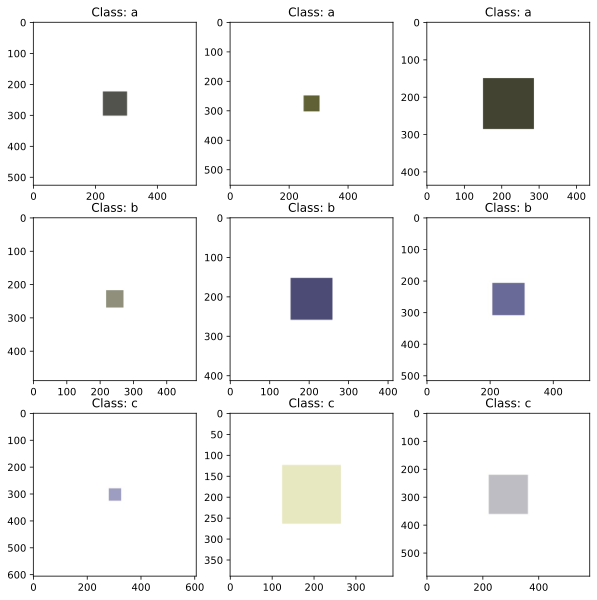

In [13]:
sample_imgs = train_data.groupby('label').sample(3)
show_images(sample_imgs['image_loc'], sample_imgs['label'])

In [19]:
## check image size across different classes

def read_image(image_loc):

  return np.array(Image.open(image_loc))

def check_image_size(df):

  return np.array(Image.open(df['image_loc'])).shape

def plot_image_size(df):

  class_df = df.groupby('label')["image_size"]
  fig, ax = plt.subplots(1, 3, figsize = (9, 3))

  for i, key in enumerate(class_df.groups.keys()):

    h = class_df.get_group(key).apply(lambda x: x[0])
    w = class_df.get_group(key).apply(lambda x: x[1])
    sns.scatterplot(w, h, ax=ax[i])
    ax[i].set_xlabel("width")
    ax[i].set_ylabel("height")
    ax[i].set_title(f"class: {key}")
  
  plt.tight_layout()
  plt.show()

In [15]:
train_data["image_size"] = train_data.apply(check_image_size, axis=1)
test_data["image_size"] = test_data.apply(check_image_size, axis=1)

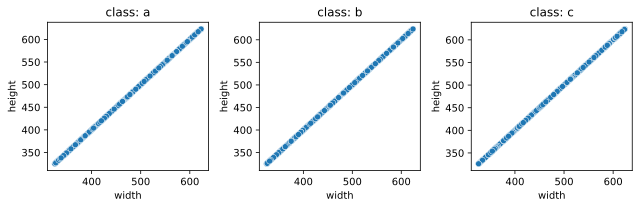

In [21]:
plot_image_size(train_data)

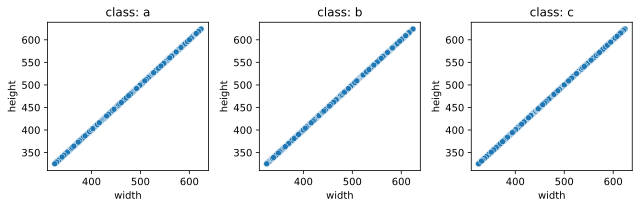

In [22]:
plot_image_size(test_data)

- compare the size ratio of square
- compare the average pixel value

In [109]:
## calculate the percentage of square
def square_percentage(img_loc):
    img = read_image(img_loc)

    return (img[:, :, 0] != 255).sum() / np.prod(img.shape[:2])

# calculate the average pixel value in the square
def avg_square_pixel(img_loc):
    img = read_image(img_loc)

    return img[img != 255].sum() / img[img != 255].shape[0]

In [112]:
train_data['square_percentage'] = train_data['image_loc'].apply(square_percentage)
train_data['avg_square_pixel'] = train_data['image_loc'].apply(avg_square_pixel)

test_data['square_percentage'] = test_data['image_loc'].apply(square_percentage)
test_data['avg_square_pixel'] = test_data['image_loc'].apply(avg_square_pixel)

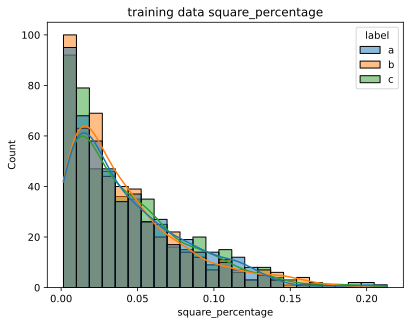

In [117]:
ax = sns.histplot(data=train_data, x='square_percentage', hue='label', kde=True)
ax.set_title("training data square_percentage")
plt.show()

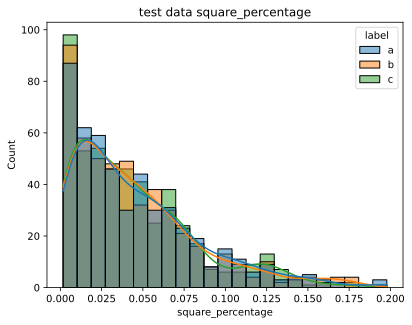

In [118]:
ax = sns.histplot(data=test_data, x='square_percentage', hue='label', kde=True)
ax.set_title("test data square_percentage")
plt.show()

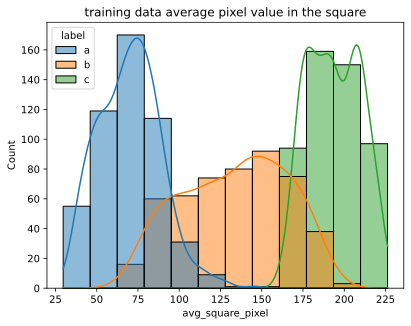

In [119]:
ax = sns.histplot(data=train_data, x='avg_square_pixel', hue='label', kde=True)
ax.set_title("training data average pixel value in the square")
plt.show()

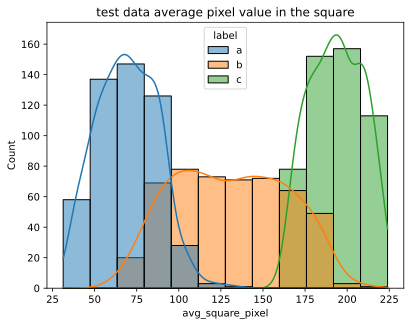

In [120]:
ax = sns.histplot(data=test_data, x='avg_square_pixel', hue='label', kde=True)
ax.set_title("test data average pixel value in the square")
plt.show()

In [113]:
train_data.head()

,image_loc,label,dataset,image_size,label_int,square_percentage,avg_square_pixel
0,./squares\train\a\0.jpg,a,train,"(462, 462, 3)",0,0.028288,80.009306
1,./squares\train\a\10.jpg,a,train,"(611, 611, 3)",0,0.007361,95.793300
2,./squares\train\a\102.jpg,a,train,"(423, 423, 3)",0,0.078271,76.568179
3,./squares\train\a\103.jpg,a,train,"(583, 583, 3)",0,0.062276,57.749580
4,./squares\train\a\106.jpg,a,train,"(354, 354, 3)",0,0.085097,86.040368


## 2. Data Splitting

In [122]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_data['label'])

train_data['label_int'] = le.transform(train_data['label'])
test_data['label_int'] = le.transform(test_data['label'])

In [123]:
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(range(len(train_data)), stratify=train_data['label_int'], test_size=0.1, random_state=42)

train_set = train_data.iloc[train_idx]
val_set = train_data.iloc[val_idx]

In [127]:
train_set

,image_loc,label,dataset,image_size,label_int,square_percentage,avg_square_pixel
1218,./squares\train\b\389.png,b,train,"(482, 482, 3)",1,0.004976,77.000000
2467,./squares\train\c\483.bmp,c,train,"(377, 377, 3)",2,0.032534,214.333333
326,./squares\train\c\106.jpg,c,train,"(342, 342, 3)",2,0.021964,221.512906
31,./squares\train\a\166.jpg,a,train,"(607, 607, 3)",0,0.052314,59.903953
2298,./squares\train\b\472.bmp,b,train,"(482, 482, 3)",1,0.022314,92.333333
...,...,...,...,...,...,...,...
61,./squares\train\a\257.jpg,a,train,"(409, 409, 3)",0,0.070277,73.694340
1444,./squares\train\c\72.png,c,train,"(465, 465, 3)",2,0.012505,181.666667
2070,./squares\train\a\298.bmp,a,train,"(533, 533, 3)",0,0.003605,81.666667
394,./squares\train\c\28.jpg,c,train,"(390, 390, 3)",2,0.029198,193.543325


## 3. Models

#### 3.1 baseline model: logistic regression

In [131]:
## normalize features
feature_names = ["square_percentage", "avg_square_pixel"]
X_train, y_train, X_val, y_val = train_set[feature_names], train_set['label_int'], val_set[feature_names], val_set['label_int']
normalizer = preprocessing.StandardScaler().fit(X_train)
X_train = normalizer.transform(X_train)
X_val = normalizer.transform(X_val)

In [135]:
lm = linear_model.LogisticRegression(multi_class='multinomial')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [138]:
## validation dataset performace
lm_prediction = lm.predict(X_val)

print(classification_report(y_val, lm_prediction, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        50
           1       0.92      0.68      0.78        50
           2       0.83      0.96      0.89        50

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



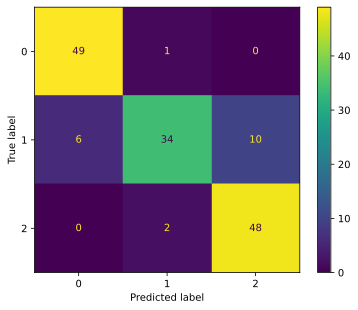

In [151]:
cm = confusion_matrix(y_val, lm_prediction, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [147]:
lm_prob = lm.predict_proba(X_val)

print("Marco AUC score: ", roc_auc_score(y_val, lm_prob, multi_class='ovr'))

Marco AUC score:  0.9686


### 3.2 Deep Learning Model

In [156]:
train_set.head()

,image_loc,label,dataset,image_size,label_int,square_percentage,avg_square_pixel
1218,./squares\train\b\389.png,b,train,"(482, 482, 3)",1,0.004976,77.000000
2467,./squares\train\c\483.bmp,c,train,"(377, 377, 3)",2,0.032534,214.333333
326,./squares\train\c\106.jpg,c,train,"(342, 342, 3)",2,0.021964,221.512906
31,./squares\train\a\166.jpg,a,train,"(607, 607, 3)",0,0.052314,59.903953
2298,./squares\train\b\472.bmp,b,train,"(482, 482, 3)",1,0.022314,92.333333


In [157]:
## make the Dataset
def set_transform(mode):

  if mode == "train" or mode == 'val':
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            )    
        ]
    )
  
  else:

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            )
        ]
    )
  
  return transform

class SquareData(Dataset):

  def __init__(self, data, mode="train"):
    self.data = data
    self.mode = mode
    self.transform = set_transform(mode)

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):

    sample = self.data.iloc[idx]
    img = Image.open(sample['image_loc'])
    img = self.transform(img)
    
    if self.mode == "train" or self.mode == "val":
      label = torch.tensor(sample['label_int'], dtype=torch.long)

      return img, label
    
    else:
      return img


In [158]:

train_dataset = SquareData(train_set, "train")
val_dataset = SquareData(val_set, "val")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [186]:
## use resnet18 as the backbone model

class BaselineResnet18(pl.LightningModule):

  def __init__(self, lr=3e-4):

    super().__init__()

    self.save_hyperparameters()

    backbone = torchvision.models.resnet18(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
    for params in self.feature_extractor.parameters():
      params.requires_grad = False

    self.fc = nn.Linear(backbone.fc.in_features, 3)

    self.loss_fun = nn.CrossEntropyLoss()

    self.train_auc = AUROC(num_classes=3)
    self.train_acc = Accuracy()
    self.val_auc = AUROC(num_classes=3)
    self.val_acc = Accuracy()

  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.squeeze(-1).squeeze(-1)
    return self.fc(x)
  
  def training_step(self, batch, batch_idx):

    imgs, labels = batch
    logits = self(imgs)
    loss = self.loss_fun(logits, labels)

    self.log("train_loss", loss, prog_bar=True)

    return {
        "loss": loss,
        "y_pred": logits,
        "y_true": labels
    }

  def training_epoch_end(self, outputs):
    y_pred = torch.cat([x['y_pred'] for x in outputs])
    y_true = torch.cat([x['y_true'] for x in outputs])

    y_prob = F.softmax(y_pred, dim=-1)

    auc = self.train_auc(y_prob, y_true)
    acc = self.train_acc(y_prob, y_true)

    self.log("train_auc", auc, prog_bar=True)
    self.log("train_acc", acc, prog_bar=True)

  
  def validation_step(self, batch, batch_idx):

    imgs, labels = batch
    logits = self(imgs)
    loss = self.loss_fun(logits, labels)

    self.log("val_loss", loss, prog_bar=True)

    return {
      "y_pred": logits,
      "y_true": labels
    }

  def validation_epoch_end(self, outputs):
    y_pred = torch.cat([x['y_pred'] for x in outputs])
    y_true = torch.cat([x['y_true'] for x in outputs])

    y_prob = F.softmax(y_pred, dim=-1)

    auc = self.val_auc(y_prob, y_true)
    acc = self.val_acc(y_prob, y_true)

    self.log("val_auc", auc, prog_bar=True)
    self.log("val_acc", acc, prog_bar=True)

  
  def predict_step(self, batch, batch_idx):

    img, label = batch

    return self(img)
    
  
  def configure_optimizers(self):

    optimizer = torch.optim.SGD(
        self.parameters(),
        lr=self.hparams.lr,
        momentum=0.9,
        weight_decay=5e-4
    )

    lr_scheduler_config = {
      "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min'),
      "monitor": "val_loss"
    }

    return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

In [187]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode="min"
)

model = BaselineResnet18()

trainer = pl.Trainer(
    max_epochs=60,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, EarlyStopping(monitor="val_loss", mode="min", patience=20)]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [166]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 11.2 M
1 | fc                | Linear           | 1.5 K 
2 | loss_fun          | CrossEntropyLoss | 0     
3 | train_auc         | AUROC            | 0     
4 | train_acc         | Accuracy         | 0     
5 | val_auc           | AUROC            | 0     
6 | val_acc           | Accuracy         | 0     
-------------------------------------------------------
1.5 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 48/48 [00:26<00:00,  1.80it/s, loss=1.09, v_num=2, train_loss=1.240, val_loss=1.080, val_auc=0.626, val_acc=0.453, train_auc=0.551, train_acc=0.365]

Epoch 0, global step 43: 'val_loss' reached 1.08398 (best 1.08398), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=0-step=43.ckpt' as top 1


Epoch 1: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=1.01, v_num=2, train_loss=0.971, val_loss=0.992, val_auc=0.730, val_acc=0.493, train_auc=0.666, train_acc=0.479]

Epoch 1, global step 86: 'val_loss' reached 0.99167 (best 0.99167), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=1-step=86.ckpt' as top 1


Epoch 2: 100%|██████████| 48/48 [00:25<00:00,  1.90it/s, loss=0.959, v_num=2, train_loss=0.965, val_loss=0.961, val_auc=0.756, val_acc=0.547, train_auc=0.729, train_acc=0.553]

Epoch 2, global step 129: 'val_loss' reached 0.96096 (best 0.96096), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=2-step=129.ckpt' as top 1


Epoch 3: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s, loss=0.924, v_num=2, train_loss=0.987, val_loss=0.924, val_auc=0.775, val_acc=0.567, train_auc=0.751, train_acc=0.561]

Epoch 3, global step 172: 'val_loss' reached 0.92393 (best 0.92393), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=3-step=172.ckpt' as top 1


Epoch 4: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s, loss=0.889, v_num=2, train_loss=0.907, val_loss=0.906, val_auc=0.783, val_acc=0.620, train_auc=0.785, train_acc=0.622]

Epoch 4, global step 215: 'val_loss' reached 0.90617 (best 0.90617), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=4-step=215.ckpt' as top 1


Epoch 5: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s, loss=0.852, v_num=2, train_loss=0.885, val_loss=0.869, val_auc=0.806, val_acc=0.613, train_auc=0.802, train_acc=0.631]

Epoch 5, global step 258: 'val_loss' reached 0.86903 (best 0.86903), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=5-step=258.ckpt' as top 1


Epoch 6: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s, loss=0.901, v_num=2, train_loss=1.210, val_loss=0.854, val_auc=0.816, val_acc=0.607, train_auc=0.794, train_acc=0.623]

Epoch 6, global step 301: 'val_loss' reached 0.85421 (best 0.85421), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=6-step=301.ckpt' as top 1


Epoch 7: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s, loss=0.817, v_num=2, train_loss=0.783, val_loss=0.823, val_auc=0.842, val_acc=0.640, train_auc=0.827, train_acc=0.682]

Epoch 7, global step 344: 'val_loss' reached 0.82298 (best 0.82298), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=7-step=344.ckpt' as top 1


Epoch 8: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s, loss=0.837, v_num=2, train_loss=1.090, val_loss=0.836, val_auc=0.842, val_acc=0.620, train_auc=0.821, train_acc=0.656]

Epoch 8, global step 387: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s, loss=0.819, v_num=2, train_loss=1.220, val_loss=0.786, val_auc=0.851, val_acc=0.647, train_auc=0.843, train_acc=0.687]

Epoch 9, global step 430: 'val_loss' reached 0.78592 (best 0.78592), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=9-step=430.ckpt' as top 1


Epoch 10: 100%|██████████| 48/48 [00:26<00:00,  1.80it/s, loss=0.796, v_num=2, train_loss=0.890, val_loss=0.768, val_auc=0.874, val_acc=0.700, train_auc=0.838, train_acc=0.689]

Epoch 10, global step 473: 'val_loss' reached 0.76808 (best 0.76808), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=10-step=473.ckpt' as top 1


Epoch 11: 100%|██████████| 48/48 [00:26<00:00,  1.78it/s, loss=0.799, v_num=2, train_loss=1.040, val_loss=0.729, val_auc=0.893, val_acc=0.753, train_auc=0.849, train_acc=0.698]

Epoch 11, global step 516: 'val_loss' reached 0.72920 (best 0.72920), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=11-step=516.ckpt' as top 1


Epoch 12: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s, loss=0.755, v_num=2, train_loss=0.687, val_loss=0.762, val_auc=0.868, val_acc=0.700, train_auc=0.865, train_acc=0.714]

Epoch 12, global step 559: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s, loss=0.773, v_num=2, train_loss=0.713, val_loss=0.785, val_auc=0.851, val_acc=0.660, train_auc=0.855, train_acc=0.701]

Epoch 13, global step 602: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s, loss=0.764, v_num=2, train_loss=0.954, val_loss=0.716, val_auc=0.876, val_acc=0.747, train_auc=0.862, train_acc=0.696]

Epoch 14, global step 645: 'val_loss' reached 0.71608 (best 0.71608), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=14-step=645.ckpt' as top 1


Epoch 15: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s, loss=0.729, v_num=2, train_loss=0.883, val_loss=0.709, val_auc=0.877, val_acc=0.760, train_auc=0.872, train_acc=0.721]

Epoch 15, global step 688: 'val_loss' reached 0.70889 (best 0.70889), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=15-step=688.ckpt' as top 1


Epoch 16: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s, loss=0.739, v_num=2, train_loss=0.838, val_loss=0.690, val_auc=0.903, val_acc=0.693, train_auc=0.866, train_acc=0.701]

Epoch 16, global step 731: 'val_loss' reached 0.68957 (best 0.68957), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=16-step=731.ckpt' as top 1


Epoch 17: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s, loss=0.74, v_num=2, train_loss=0.575, val_loss=0.704, val_auc=0.884, val_acc=0.727, train_auc=0.869, train_acc=0.723] 

Epoch 17, global step 774: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s, loss=0.698, v_num=2, train_loss=0.524, val_loss=0.698, val_auc=0.888, val_acc=0.753, train_auc=0.880, train_acc=0.727]

Epoch 18, global step 817: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s, loss=0.711, v_num=2, train_loss=0.760, val_loss=0.720, val_auc=0.880, val_acc=0.693, train_auc=0.880, train_acc=0.734]

Epoch 19, global step 860: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s, loss=0.705, v_num=2, train_loss=1.230, val_loss=0.682, val_auc=0.900, val_acc=0.693, train_auc=0.886, train_acc=0.741]

Epoch 20, global step 903: 'val_loss' reached 0.68212 (best 0.68212), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=20-step=903.ckpt' as top 1


Epoch 21: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s, loss=0.714, v_num=2, train_loss=1.010, val_loss=0.672, val_auc=0.891, val_acc=0.693, train_auc=0.882, train_acc=0.732]

Epoch 21, global step 946: 'val_loss' reached 0.67241 (best 0.67241), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=21-step=946.ckpt' as top 1


Epoch 22: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s, loss=0.678, v_num=2, train_loss=0.695, val_loss=0.706, val_auc=0.867, val_acc=0.733, train_auc=0.880, train_acc=0.736]

Epoch 22, global step 989: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 48/48 [00:24<00:00,  1.94it/s, loss=0.716, v_num=2, train_loss=1.080, val_loss=0.683, val_auc=0.888, val_acc=0.700, train_auc=0.880, train_acc=0.739]

Epoch 23, global step 1032: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s, loss=0.653, v_num=2, train_loss=0.722, val_loss=0.651, val_auc=0.900, val_acc=0.753, train_auc=0.892, train_acc=0.746]

Epoch 24, global step 1075: 'val_loss' reached 0.65148 (best 0.65148), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=24-step=1075.ckpt' as top 1


Epoch 25: 100%|██████████| 48/48 [00:26<00:00,  1.78it/s, loss=0.675, v_num=2, train_loss=0.556, val_loss=0.667, val_auc=0.894, val_acc=0.727, train_auc=0.886, train_acc=0.738]

Epoch 25, global step 1118: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 48/48 [00:27<00:00,  1.78it/s, loss=0.682, v_num=2, train_loss=0.765, val_loss=0.679, val_auc=0.886, val_acc=0.727, train_auc=0.885, train_acc=0.734]

Epoch 26, global step 1161: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s, loss=0.68, v_num=2, train_loss=1.150, val_loss=0.678, val_auc=0.893, val_acc=0.680, train_auc=0.885, train_acc=0.744] 

Epoch 27, global step 1204: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s, loss=0.631, v_num=2, train_loss=0.588, val_loss=0.626, val_auc=0.908, val_acc=0.760, train_auc=0.889, train_acc=0.739]

Epoch 28, global step 1247: 'val_loss' reached 0.62637 (best 0.62637), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=28-step=1247.ckpt' as top 1


Epoch 29: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s, loss=0.661, v_num=2, train_loss=0.798, val_loss=0.701, val_auc=0.883, val_acc=0.673, train_auc=0.892, train_acc=0.747]

Epoch 29, global step 1290: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s, loss=0.643, v_num=2, train_loss=0.718, val_loss=0.639, val_auc=0.900, val_acc=0.733, train_auc=0.896, train_acc=0.759]

Epoch 30, global step 1333: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s, loss=0.667, v_num=2, train_loss=0.562, val_loss=0.625, val_auc=0.915, val_acc=0.707, train_auc=0.891, train_acc=0.740]

Epoch 31, global step 1376: 'val_loss' reached 0.62540 (best 0.62540), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=31-step=1376.ckpt' as top 1


Epoch 32: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s, loss=0.678, v_num=2, train_loss=1.580, val_loss=0.568, val_auc=0.936, val_acc=0.793, train_auc=0.899, train_acc=0.756]

Epoch 32, global step 1419: 'val_loss' reached 0.56820 (best 0.56820), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=32-step=1419.ckpt' as top 1


Epoch 33: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s, loss=0.659, v_num=2, train_loss=0.917, val_loss=0.620, val_auc=0.909, val_acc=0.747, train_auc=0.888, train_acc=0.741]

Epoch 33, global step 1462: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 48/48 [00:28<00:00,  1.69it/s, loss=0.634, v_num=2, train_loss=0.613, val_loss=0.612, val_auc=0.917, val_acc=0.773, train_auc=0.896, train_acc=0.739]

Epoch 34, global step 1505: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s, loss=0.625, v_num=2, train_loss=0.979, val_loss=0.675, val_auc=0.881, val_acc=0.687, train_auc=0.899, train_acc=0.758]

Epoch 35, global step 1548: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 48/48 [00:30<00:00,  1.60it/s, loss=0.649, v_num=2, train_loss=0.830, val_loss=0.565, val_auc=0.933, val_acc=0.787, train_auc=0.894, train_acc=0.744]

Epoch 36, global step 1591: 'val_loss' reached 0.56548 (best 0.56548), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=36-step=1591.ckpt' as top 1


Epoch 37: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s, loss=0.656, v_num=2, train_loss=1.010, val_loss=0.588, val_auc=0.912, val_acc=0.760, train_auc=0.889, train_acc=0.741]

Epoch 37, global step 1634: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s, loss=0.592, v_num=2, train_loss=0.676, val_loss=0.599, val_auc=0.923, val_acc=0.820, train_auc=0.907, train_acc=0.763]

Epoch 38, global step 1677: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 48/48 [00:28<00:00,  1.69it/s, loss=0.638, v_num=2, train_loss=0.521, val_loss=0.618, val_auc=0.906, val_acc=0.733, train_auc=0.895, train_acc=0.752]

Epoch 39, global step 1720: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s, loss=0.603, v_num=2, train_loss=0.442, val_loss=0.565, val_auc=0.929, val_acc=0.773, train_auc=0.914, train_acc=0.767]

Epoch 40, global step 1763: 'val_loss' reached 0.56500 (best 0.56500), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=40-step=1763.ckpt' as top 1


Epoch 41: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s, loss=0.586, v_num=2, train_loss=0.568, val_loss=0.623, val_auc=0.898, val_acc=0.727, train_auc=0.913, train_acc=0.770]

Epoch 41, global step 1806: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s, loss=0.616, v_num=2, train_loss=0.490, val_loss=0.541, val_auc=0.937, val_acc=0.813, train_auc=0.911, train_acc=0.761]

Epoch 42, global step 1849: 'val_loss' reached 0.54090 (best 0.54090), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=42-step=1849.ckpt' as top 1


Epoch 43: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.599, v_num=2, train_loss=0.588, val_loss=0.623, val_auc=0.909, val_acc=0.693, train_auc=0.903, train_acc=0.756]

Epoch 43, global step 1892: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s, loss=0.609, v_num=2, train_loss=0.670, val_loss=0.597, val_auc=0.904, val_acc=0.747, train_auc=0.908, train_acc=0.763]

Epoch 44, global step 1935: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s, loss=0.657, v_num=2, train_loss=0.676, val_loss=0.539, val_auc=0.946, val_acc=0.820, train_auc=0.905, train_acc=0.763]

Epoch 45, global step 1978: 'val_loss' reached 0.53909 (best 0.53909), saving model to 'logs/lightning_logs\\version_2\\checkpoints\\epoch=45-step=1978.ckpt' as top 1


Epoch 46: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.583, v_num=2, train_loss=0.433, val_loss=0.546, val_auc=0.939, val_acc=0.800, train_auc=0.912, train_acc=0.759]

Epoch 46, global step 2021: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 48/48 [00:28<00:00,  1.71it/s, loss=0.571, v_num=2, train_loss=0.441, val_loss=0.546, val_auc=0.928, val_acc=0.773, train_auc=0.910, train_acc=0.777]

Epoch 47, global step 2064: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 48/48 [00:27<00:00,  1.78it/s, loss=0.61, v_num=2, train_loss=0.503, val_loss=0.607, val_auc=0.908, val_acc=0.747, train_auc=0.907, train_acc=0.777] 

Epoch 48, global step 2107: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s, loss=0.58, v_num=2, train_loss=0.725, val_loss=0.598, val_auc=0.902, val_acc=0.760, train_auc=0.914, train_acc=0.779] 

Epoch 49, global step 2150: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s, loss=0.588, v_num=2, train_loss=0.887, val_loss=0.580, val_auc=0.916, val_acc=0.740, train_auc=0.907, train_acc=0.770]

Epoch 50, global step 2193: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s, loss=0.631, v_num=2, train_loss=0.903, val_loss=0.558, val_auc=0.924, val_acc=0.780, train_auc=0.899, train_acc=0.756]

Epoch 51, global step 2236: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s, loss=0.57, v_num=2, train_loss=0.351, val_loss=0.596, val_auc=0.902, val_acc=0.747, train_auc=0.904, train_acc=0.770] 

Epoch 52, global step 2279: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s, loss=0.604, v_num=2, train_loss=0.819, val_loss=0.551, val_auc=0.935, val_acc=0.800, train_auc=0.910, train_acc=0.773]

Epoch 53, global step 2322: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.6, v_num=2, train_loss=0.553, val_loss=0.589, val_auc=0.926, val_acc=0.787, train_auc=0.905, train_acc=0.770]  

Epoch 54, global step 2365: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s, loss=0.593, v_num=2, train_loss=0.778, val_loss=0.594, val_auc=0.906, val_acc=0.700, train_auc=0.915, train_acc=0.776]

Epoch 55, global step 2408: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 48/48 [00:26<00:00,  1.83it/s, loss=0.579, v_num=2, train_loss=0.734, val_loss=0.622, val_auc=0.895, val_acc=0.747, train_auc=0.921, train_acc=0.788]

Epoch 56, global step 2451: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.578, v_num=2, train_loss=0.589, val_loss=0.558, val_auc=0.931, val_acc=0.767, train_auc=0.926, train_acc=0.796]

Epoch 57, global step 2494: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 48/48 [00:26<00:00,  1.78it/s, loss=0.574, v_num=2, train_loss=0.579, val_loss=0.598, val_auc=0.901, val_acc=0.707, train_auc=0.924, train_acc=0.796]

Epoch 58, global step 2537: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.592, v_num=2, train_loss=0.833, val_loss=0.594, val_auc=0.911, val_acc=0.767, train_auc=0.919, train_acc=0.775]

Epoch 59, global step 2580: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s, loss=0.592, v_num=2, train_loss=0.833, val_loss=0.594, val_auc=0.911, val_acc=0.767, train_auc=0.919, train_acc=0.775]


In [176]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics['step']
metrics.set_index('epoch', inplace=True)

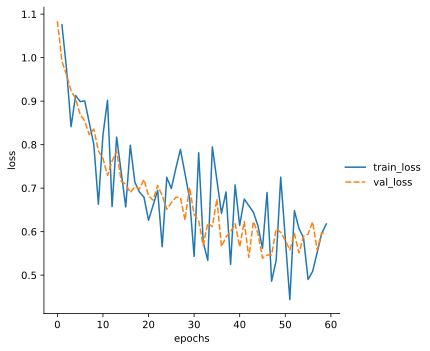

In [183]:
ax = sns.relplot(data = metrics[['train_loss', 'val_loss']].dropna(how='all'), kind='line')
ax.set(xlabel="epochs", ylabel="loss")
plt.show()

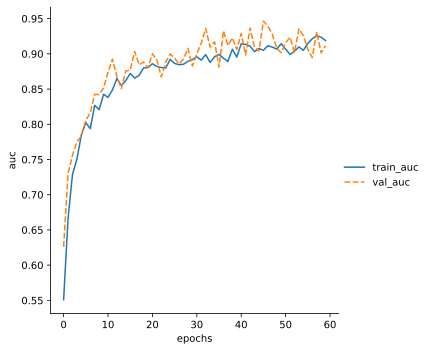

In [184]:
ax = sns.relplot(data = metrics[['train_auc', 'val_auc']].dropna(how='all'), kind='line')
ax.set(xlabel="epochs", ylabel="auc")
plt.show()

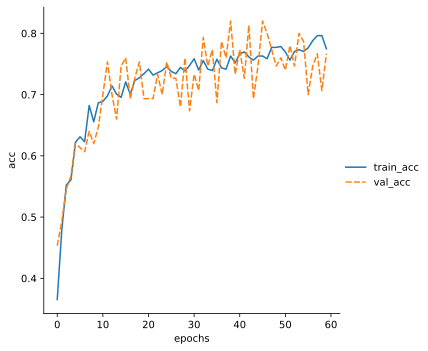

In [185]:
ax = sns.relplot(data = metrics[['train_acc', 'val_acc']].dropna(how='all'), kind='line')
ax.set(xlabel="epochs", ylabel="acc")
plt.show()

In [200]:
## prediction on validation set
model_path = os.path.join(".", "logs/lightning_logs/version_2/checkpoints/epoch=45-step=1978.ckpt")
model = BaselineResnet18.load_from_checkpoint(model_path)
val_prediction = trainer.predict(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


In [234]:
val_pred = F.softmax(torch.concat([x for x in val_prediction]), dim=-1).numpy()

In [213]:
print("Validation set accuracy: ", accuracy_score(val_set['label_int'], val_pred.argmax(axis=-1)))

Validation set accuracy:  0.7933333333333333


In [235]:
val_pred_max_prob = np.amax(val_pred, axis=1)
val_pred_label = val_pred.argmax(axis=-1)

prediction_val_set = pd.DataFrame({'prediction': val_pred_label, 'prob': val_pred_max_prob})

In [237]:
val_set_pred = val_set.reset_index(drop=True).merge(prediction_val_set, left_index=True, right_index=True)

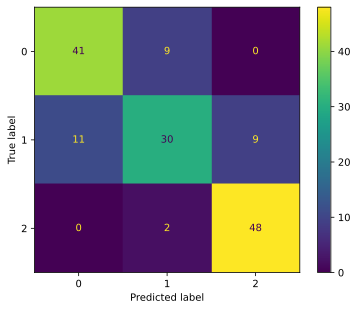

In [248]:
cm = confusion_matrix(val_set_pred['label_int'], val_set_pred['prediction'], labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

## 4. Error Analysis
- Plot the bad performance cases
- Add some data augmentation to class b since it's performance is worst

***Future work if I have more time***
- Machine Learning
    - Construct more features
    - Try different models
- Deep Learning
    - Use [Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam) to draw the heatmap
    - Identify different data augmentation which may help to improve the model performace

In [240]:
## pick the error cases
error_cases = val_set_pred.loc[val_set_pred.label_int != val_set_pred.prediction].sort_values(by='prob', ascending=False)
error_cases.head()

,image_loc,label,dataset,image_size,label_int,square_percentage,avg_square_pixel,prediction,prob
83,./squares\train\b\382.png,b,train,"(452, 452, 3)",1,0.041428,133.333333,0,0.893971
134,./squares\train\b\203.jpg,b,train,"(352, 352, 3)",1,0.027957,92.719312,0,0.840457
96,./squares\train\b\22.bmp,b,train,"(455, 455, 3)",1,0.046391,75.000000,0,0.789378
90,./squares\train\b\343.png,b,train,"(444, 444, 3)",1,0.005194,102.333333,2,0.635987
108,./squares\train\b\270.bmp,b,train,"(522, 522, 3)",1,0.005299,117.333333,2,0.634198


In [241]:
def plot_image(img_loc, gd, pred):
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(Image.open(img_loc))
    ax.set_title(f"gd: {gd}, pred: {pred}")

    plt.show()

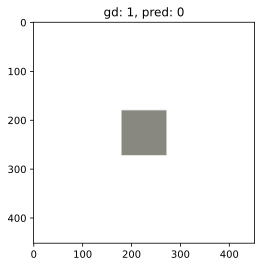

In [246]:
plot_image(*error_cases.iloc[0].loc[['image_loc','label_int', 'prediction']].to_list())

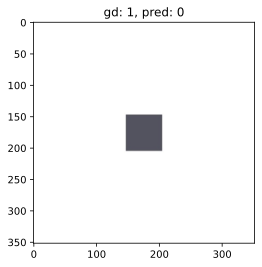

In [247]:
plot_image(*error_cases.iloc[1].loc[['image_loc','label_int', 'prediction']].to_list())

## 5. Prediction on Test Data

#### 5.1 Test Data Prediction with Logistic Regression

In [250]:

X_test, y_test = test_data[feature_names], test_data['label_int']
X_test = normalizer.transform(X_test)

lm_test = lm.predict(X_test)

print(classification_report(y_test, lm_test, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       500
           1       0.82      0.70      0.75       500
           2       0.88      0.93      0.90       500

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



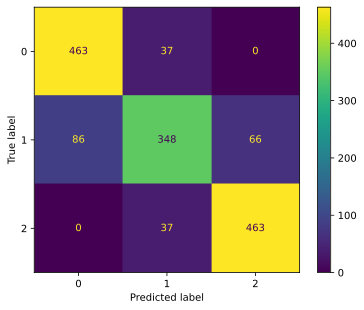

In [251]:
cm = confusion_matrix(y_test, lm_test, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [252]:
lm_prob_test = lm.predict_proba(X_test)

print("Marco AUC score: ", roc_auc_score(y_test, lm_prob_test, multi_class='ovr'))

Marco AUC score:  0.9576199999999999


#### 5.2 Test Data Prediction with DL

In [253]:

test_dataset = SquareData(test_data, "val")

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_prediction = trainer.predict(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


In [254]:
test_pred = F.softmax(torch.concat([x for x in test_prediction]), dim=-1).numpy()

print(classification_report(y_test, test_pred.argmax(axis=-1), labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       500
           1       0.73      0.64      0.68       500
           2       0.82      0.89      0.85       500

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



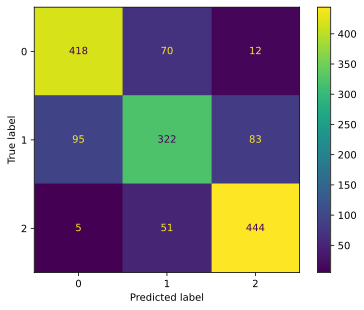

In [255]:
cm = confusion_matrix(y_test, test_pred.argmax(axis=-1), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [256]:

print("Marco AUC score: ", roc_auc_score(y_test, test_pred, multi_class='ovr'))

Marco AUC score:  0.9219599999999999
